In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Conv1D, MaxPooling1D, Dropout, Activation
from keras.preprocessing import sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from string import punctuation

import re
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
# from nltk.corpus import stopwords
# stop_words=set(nltk.corpus.stopwords.words('english'))

/Users/marto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
Using TensorFlow backend.


# Sentiment Analysis with LSTM
## Build a classifier using LSTM with Keras

1. Load data and visualize it.
I will use Women's E-Commerce Clothing Reviews from Kaggle, contains information about women clothes reviews writen by users. 

In [3]:
reviews_data = pd.read_csv("./data/Womens Clothing E-Commerce Reviews.csv")

In [4]:
reviews_data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


2. Data Processing

First I will get reviews's text and Recommended IND, which I will use as label to train my neural netowrk.

In [28]:
reviews = reviews_data[["Review Text", "Recommended IND"]]

Преглеждам ги отново, да видя дали съм взел правилните неща :)

In [29]:
reviews.shape

(23486, 2)

Ще сменя само имената на колоните, за да мога да ги достъпвам по лесно.
I will change column names to can word with them more ...

In [30]:
reviews.columns = ["review_text", "recommended"]

In [31]:
reviews.head()

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


Lets continue with text preprocessing. Convert all reviews to lower case.

In [32]:
reviews["review_text"] = reviews["review_text"].str.lower()

/Users/marto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
reviews["review_text"] = reviews["review_text"].apply(lambda x: re.sub(r'\d+', "", str(x)))

/Users/marto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Next step is to remove punctuation from reviews.

In [37]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [38]:
reviews.review_text = reviews.review_text.str.replace('[{}]'.format(punctuation), ' ')
reviews.review_text.head()

0    absolutely wonderful   silky and sexy and comf...
1    love this dress   it s sooo pretty   i happene...
2    i had such high hopes for this dress and reall...
3    i love  love  love this jumpsuit  it s fun  fl...
4    this shirt is very flattering to all due to th...
Name: review_text, dtype: object

In [39]:
def check_for_word(s):
    return ' '.join(w for w in s if len(wordnet.synsets(w)) > 0)

Lemmatize

In [40]:
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

In [41]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


In [42]:
reviews["review_lemmatized"] = reviews.review_text.apply(lemmatize_text)
reviews['review_lemmatized'].head()

0    [absolutely, wonderful, silky, and, sexy, and,...
1    [love, this, dress, it, s, sooo, pretty, i, ha...
2    [i, had, such, high, hope, for, this, dress, a...
3    [i, love, love, love, this, jumpsuit, it, s, f...
4    [this, shirt, is, very, flattering, to, all, d...
Name: review_lemmatized, dtype: object

In [43]:
reviews['keywords'] = reviews.review_lemmatized.apply(check_for_word)
reviews['keywords'].head()

0          absolutely wonderful silky sexy comfortable
1    love dress it s pretty i happened find it in a...
2    i had such high hope dress really wanted it wo...
3    i love love love jumpsuit it s fun fabulous ev...
4    shirt is very flattering all due adjustable fr...
Name: keywords, dtype: object

I will remove all rows with null or empty values.

In [44]:
# reviews["review_lemmatized"] = reviews.review_text.apply(lemmatize_text)
reviews = reviews[~reviews.keywords.str.contains("nan")]
reviews.sample(5)

,review_text,recommended,review_lemmatized,keywords
2944,i bought this top in the store where i found t...,1,"[i, bought, this, top, in, the, store, where, ...",i bought top in store i found had a beautiful ...
14941,i bought this top on a whim it s not my st...,1,"[i, bought, this, top, on, a, whim, it, s, not...",i bought top on a whim it s not style but want...
19010,i just purchased this cardigan it is better i...,1,"[i, just, purchased, this, cardigan, it, is, b...",i just purchased cardigan it is better in pers...
13459,this top exceeded my expectations i got it in...,1,"[this, top, exceeded, my, expectation, i, got,...",top exceeded expectation i got it in gray stri...
8505,i ordered the white tee in xs and am returning...,1,"[i, ordered, the, white, tee, in, x, and, am, ...",i ordered white tee in x am returning it it ru...


Tokenize - I will build a lookup dictionary by creating a mapping between words and index, i.e. each unique word in the vocabulary is assigned an index. Words with higher frequency will have lower indexes.

In [45]:
all_reviews = reviews.keywords.tolist()

In [54]:
all_words = []
for sentince in all_reviews:
    for word in sentince.split(" "):
        all_words.append(word)


In [55]:
all_text = " ".join(all_words)

In [56]:
# create a list of words
words = all_text.split()

In [57]:
# Count all the words using Counter
count_words = Counter(words)

In [58]:
total_words = len(words)

In [59]:
sorted_words = count_words.most_common(total_words)

In [60]:
print (count_words)

Counter({'i': 66345, 'it': 49641, 'a': 49366, 'is': 30366, 'in': 20555, 'but': 16406, 'on': 15183, 'wa': 12081, 'so': 11922, 'dress': 11321, 'fit': 10099, 'not': 9714, 'size': 9372, 'love': 8941, 's': 8910, 't': 8788, 'top': 8244, 'very': 8167, 'have': 7971, 'are': 7239, 'like': 7090, 'be': 6955, 'color': 6930, 'look': 6786, 'm': 6621, 'me': 6595, 'wear': 6478, 'great': 6065, 'too': 6002, 'or': 5773, 'am': 5652, 'just': 5565, 'fabric': 4838, 'up': 4818, 'at': 4763, 'small': 4709, 'can': 4024, 'more': 3916, 'really': 3893, 'ordered': 3826, 'little': 3754, 'perfect': 3746, 'one': 3702, 'will': 3580, 'flattering': 3485, 'well': 3358, 'an': 3336, 'soft': 3325, 'out': 3298, 'back': 3218, 'had': 3138, 'shirt': 3082, 'comfortable': 3043, 'cute': 3018, 'nice': 2998, 'bought': 2950, 'beautiful': 2938, 'all': 2886, 'bit': 2859, 'large': 2823, 'down': 2810, 'material': 2800, 'sweater': 2747, 'much': 2682, 'length': 2669, 'jean': 2635, 'run': 2621, 'also': 2556, 'ha': 2541, 'work': 2525, 'long': 2

In [61]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [62]:
print(vocab_to_int)

{'i': 1, 'it': 2, 'a': 3, 'is': 4, 'in': 5, 'but': 6, 'on': 7, 'wa': 8, 'so': 9, 'dress': 10, 'fit': 11, 'not': 12, 'size': 13, 'love': 14, 's': 15, 't': 16, 'top': 17, 'very': 18, 'have': 19, 'are': 20, 'like': 21, 'be': 22, 'color': 23, 'look': 24, 'm': 25, 'me': 26, 'wear': 27, 'great': 28, 'too': 29, 'or': 30, 'am': 31, 'just': 32, 'fabric': 33, 'up': 34, 'at': 35, 'small': 36, 'can': 37, 'more': 38, 'really': 39, 'ordered': 40, 'little': 41, 'perfect': 42, 'one': 43, 'will': 44, 'flattering': 45, 'well': 46, 'an': 47, 'soft': 48, 'out': 49, 'back': 50, 'had': 51, 'shirt': 52, 'comfortable': 53, 'cute': 54, 'nice': 55, 'bought': 56, 'beautiful': 57, 'all': 58, 'bit': 59, 'large': 60, 'down': 61, 'material': 62, 'sweater': 63, 'much': 64, 'length': 65, 'jean': 66, 'run': 67, 'also': 68, 'ha': 69, 'work': 70, 'long': 71, 'petite': 72, 'short': 73, 'got': 74, 'waist': 75, 'x': 76, 'quality': 77, 'medium': 78, 'skirt': 79, 'pretty': 80, 'think': 81, 'retailer': 82, 'even': 83, 'store':

Encode the words in reviews. Replace words in reviews by integers.

In [65]:
def encode_reviews(review):
    reviews_int = []
    encoded = [vocab_to_int[w] for w in review.split()]
    return encoded

In [66]:
reviews.encoded = reviews.keywords.apply(encode_reviews)

In [67]:
reviews.encoded[0:5]

0                             [220, 459, 781, 563, 53]
1    [14, 10, 2, 15, 80, 1, 1108, 194, 2, 5, 3, 84,...
2    [1, 51, 273, 157, 448, 10, 39, 178, 2, 70, 26,...
3    [1, 14, 14, 14, 492, 2, 15, 247, 670, 274, 131...
4    [52, 4, 18, 45, 58, 421, 978, 139, 358, 2, 4, ...
Name: keywords, dtype: object

Analyze Reviews Length

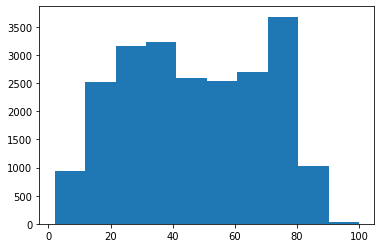

In [68]:
reviews_len = reviews.encoded.apply(lambda x: len(x))
plt.hist(reviews_len)
plt.show()

In [69]:
reviews_len.describe()

count    22453.000000
mean        47.026589
std         22.221819
min          2.000000
25%         28.000000
50%         46.000000
75%         68.000000
max        100.000000
Name: keywords, dtype: float64

Some observations: a) Mean review length = 27 b) there are no reviews with 0 length c) More of reviews are less than 40 words

Padding / Truncating the remaining data. I will define the Sequence length. This sequence length is same as number of time steps for LSTM layer.

In [70]:
seq_length=100
vocab_size = len(vocab_to_int) + 1
output_size = 1
units = 512
hidden_size = 256

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
        reviews.encoded, reviews.recommended,stratify=reviews.recommended, test_size=0.1, shuffle= True)

In [72]:
X_train = list(X_train)
X_test= list(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [73]:
X_train = sequence.pad_sequences(X_train, maxlen=seq_length) 
X_test = sequence.pad_sequences(X_test, maxlen=seq_length)

Spliting features in Training, Validation and Test Datasets,
train = 90% | test = 10%

От това се вижда, че трабва така да се разделят, че пропорцията между препоръчвани и непрепоръчвани да се запази. Ще използва за тази цел train_test_split with stratified splitting.

Define the LSTM Network Model

In [80]:
model = Sequential()
model.add(Embedding(vocab_size, hidden_size, input_length=seq_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 256)          2346496   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           24608     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1116160   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 3,487,777
Trainable params: 3,487,777
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.33)

Train on 13538 samples, validate on 6669 samples
Epoch 1/2
13538/13538 [==============================] - 214s 16ms/step - loss: 0.3709 - acc: 0.8279 - val_loss: 0.3161 - val_acc: 0.8586
Epoch 2/2
13538/13538 [==============================] - 199s 15ms/step - loss: 0.2332 - acc: 0.9010 - val_loss: 0.2814 - val_acc: 0.8790


In [83]:
print(history.history["loss"])
print(history.history["acc"])
print(history.history["val_loss"])
print(history.history["val_acc"])

[0.3708626501386566, 0.23315676167543467]
[0.8278918599585765, 0.9010193529412919]
[0.3160525603368733, 0.2813684530595304]
[0.8585994901873751, 0.8789923526944383]


### Diagnostic Plot

I can plot the performace of the model using PyPlot library.

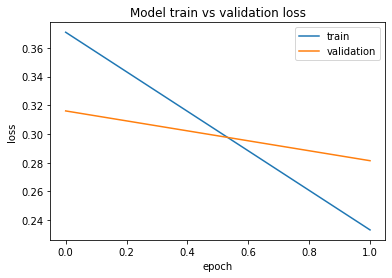

In [84]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

Here I will show the metrics - Precision, Recal и F1 into test set.

In [85]:
y_pred = model.predict(X_test, verbose=0)

In [86]:
yhat_classes = model.predict_classes(X_test, verbose=0)

In [87]:
# reduce to 1d array
yhat_probs = y_pred[:, 0]
yhat_classes = yhat_classes[:, 0]

In [88]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.886910
Precision: 0.933406
Recall: 0.928339
F1 score: 0.930866
